In [73]:
import optimizers as opt
import helper_functions as helpers
import numpy as np

In [75]:
weight, weights, costs = helpers.get_data(r"Datasets\Data50.txt")
test = opt.SAO(len(weights))
res, sol = test.main_loop(10_000, weight, weights, costs, decay_function=lambda x: np.exp(-x/10 ** 3), verbose=False)
print(f"The answer should have weight not bigger than {weight}. Answer weight is", sum(weights * sol))
print(res)

The answer should have weight not bigger than 1989. Answer weight is 1978
3055


The answer should have weight not bigger than 1989. Answer weight is 1988
3230


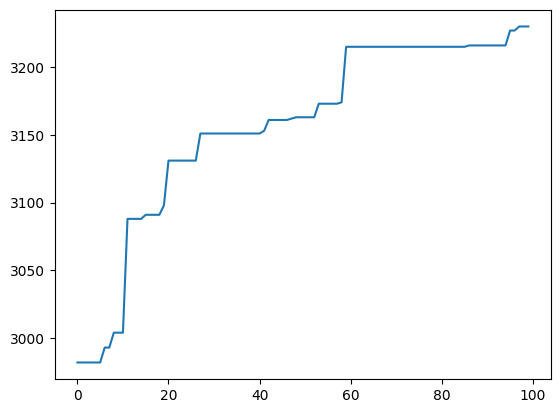

In [76]:
weight, weights, costs = helpers.get_data(r"Datasets\Data50.txt")
test2 = opt.GO(100, len(weights))
res, sol = test2.main_loop(100, 50, 0.3, weight, weights, costs, verbose=False, gif_name=r"Gifs\GO")
print(f"The answer should have weight not bigger than {weight}. Answer weight is", sum(weights * sol))
print(res)

The answer should have weight not bigger than 1200. Answer weight is 1197
5706


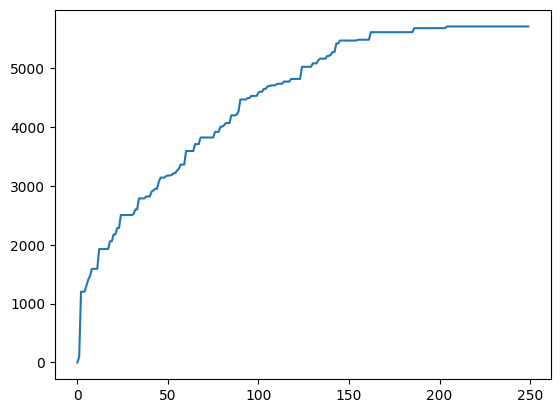

In [77]:
num = 250
weight = 1200

weights, costs = helpers.create_test_case(num, 250)
test2 = opt.GO(100, num)
res, sol = test2.main_loop(250, 50, 0.3, weight, weights, costs, verbose=False, gif_name=r"Gifs\GO_test")
print(f"The answer should have weight not bigger than {weight}. Answer weight is", sum(weights * sol))
print(res)